In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import random
import lib
from sklearn.model_selection import train_test_split

In [2]:
X_val, y_val, X_test, y_test = lib.load_dataset("../dataset", rgb=False)

In [3]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

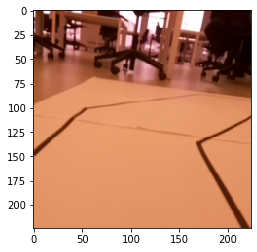

In [4]:
show_image(X_val[200])

In [5]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [6]:
config = Config(
    gaussian_blur_kernel_size=(7, 7),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.25,
    canny_threshold1=190,
    canny_threshold2=250,
)

In [7]:
def preprocess(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
    if show:
        show_image(edges)
    
    return edges

In [8]:
Xc_val = [preprocess(x) for x in X_val]

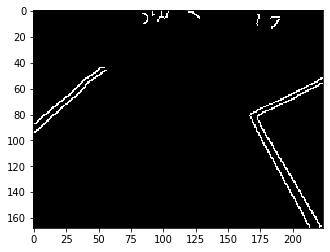

In [9]:
show_image(Xc_val[200])

In [10]:
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc_val, y_val, test_size=0.2, random_state=42)

In [11]:
Xc_test = [preprocess(x) for x in X_test]
yc_test = y_test

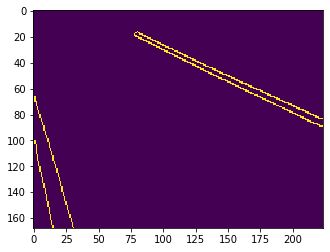

In [12]:
plt.imshow(Xc_val[0])

In [13]:
from skimage.feature import hog
from xgboost import XGBRegressor

class HoGCannyEstimator(lib.Estimator):
    def __init__(
        self,
        orientations=8,
        ppc=16,
        cpb=1,
        classifier=XGBRegressor
    ):
        self.orientations = orientations
        self.ppc = ppc
        self.cpb = cpb
        self.classifier = classifier()
        
    def fit(self, X, y):
        feats = [self._hog(x) for x in X]
        X_2d = np.array(feats).reshape((len(feats), len(feats[0])))
        self.classifier.fit(X_2d, y)

    def _hog(self, img):
        return hog(
            img,
            orientations=self.orientations, 
            pixels_per_cell=(self.ppc, self.ppc),
            cells_per_block=(self.cpb, self.cpb),
        )

    def predict_one(self, img):
        gradients = self._hog(img)
        X_2d = np.array(gradients).reshape((1, len(gradients)))
        return self.classifier.predict(X_2d)[0]

In [14]:
import time

scores = {}

for orientations in [4, 8, 16]:
    for ppc in [16, 24, 32, 64]:
        for cpb in [1, 2, 3]:
            s = time.time()
            estimator = HoGCannyEstimator(orientations=orientations, ppc=ppc, cpb=cpb)
            estimator.fit(Xc_train, yc_train)
            
            score = estimator.score(Xc_val, yc_val)
            scores[(orientations, ppc, cpb)] = score
            
            print(f"score: {score}, took: {time.time()-s} seconds, o: {orientations}, ppc: {ppc}, cpb: {cpb}")

score: (0.061177034913443826, 0.15844874341291357), took: 27.08832287788391 seconds, o: 4, ppc: 16, cpb: 1
score: (0.05636926547312426, 0.15283452507730677), took: 37.45055603981018 seconds, o: 4, ppc: 16, cpb: 2
score: (0.06158946555262189, 0.15662074896492825), took: 74.38180947303772 seconds, o: 4, ppc: 16, cpb: 3
score: (0.04615792244348605, 0.1395448926989789), took: 45.77247881889343 seconds, o: 4, ppc: 24, cpb: 1
score: (0.04971628879655154, 0.1429287705336114), took: 71.5931043624878 seconds, o: 4, ppc: 24, cpb: 2
score: (0.047714973320762376, 0.13780819372861866), took: 62.20968174934387 seconds, o: 4, ppc: 24, cpb: 3
score: (0.04640250803588366, 0.13948192273199947), took: 57.315157651901245 seconds, o: 4, ppc: 32, cpb: 1
score: (0.04413169069691472, 0.13391973779672137), took: 61.578222036361694 seconds, o: 4, ppc: 32, cpb: 2
score: (0.04902282468453153, 0.13632817781669715), took: 68.26466155052185 seconds, o: 4, ppc: 32, cpb: 3
score: (0.06196387304074945, 0.16245748526103

XGBoostError: [13:41:55] /workspace/src/learner.cc:946: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) /home/nockty/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x54) [0x7f7c006cb614]
  [bt] (1) /home/nockty/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::ConfigureNumFeatures()+0x600) [0x7f7c007afff0]
  [bt] (2) /home/nockty/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::Configure()+0x385) [0x7f7c007bcb75]
  [bt] (3) /home/nockty/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x6d) [0x7f7c007b769d]
  [bt] (4) /home/nockty/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x29) [0x7f7c006ba639]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f7c9082b81e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7f7c9082b1ef]
  [bt] (7) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x581) [0x7f7c8f84e581]
  [bt] (8) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x12aac) [0x7f7c8f84eaac]



In [15]:
import pprint

pprint.pprint(scores)

{(4, 16, 1): (0.061177034913443826, 0.15844874341291357),
 (4, 16, 2): (0.05636926547312426, 0.15283452507730677),
 (4, 16, 3): (0.06158946555262189, 0.15662074896492825),
 (4, 24, 1): (0.04615792244348605, 0.1395448926989789),
 (4, 24, 2): (0.04971628879655154, 0.1429287705336114),
 (4, 24, 3): (0.047714973320762376, 0.13780819372861866),
 (4, 32, 1): (0.04640250803588366, 0.13948192273199947),
 (4, 32, 2): (0.04413169069691472, 0.13391973779672137),
 (4, 32, 3): (0.04902282468453153, 0.13632817781669715),
 (4, 64, 1): (0.06196387304074945, 0.16245748526103584),
 (4, 64, 2): (0.05667634605605132, 0.14667567386415156)}


In [16]:
print(min([(k, v) for k, v in scores.items()], key=lambda x: x[1][0]))
print(min([(k, v) for k, v in scores.items()], key=lambda x: x[1][1]))
print(min([(k, v) for k, v in scores.items()], key=lambda x: x[1][0]+x[1][1]))

((4, 32, 2), (0.04413169069691472, 0.13391973779672137))
((4, 32, 2), (0.04413169069691472, 0.13391973779672137))
((4, 32, 2), (0.04413169069691472, 0.13391973779672137))


In [17]:
estimator = HoGCannyEstimator(orientations=4, ppc=32, cpb=2)
estimator.fit(Xc_train, yc_train)

In [18]:
estimator.score(Xc_test, yc_test)

(0.052998993301306724, 0.1399609809482677)